In [1]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 88.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 73.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 67.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 16.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 8.8 MB/s eta 0:00:00:00:0100:0

In [2]:
from keras.models import load_model

SIZE=64
# Define the known classes
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the known classes
le.fit(classes)
label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}
# Load the model
efficientnet = load_model('/kaggle/input/efficientnet/keras/efficientnet/1/efficientnet.h5')
densenet = load_model('/kaggle/input/densenet/keras/densenet/1/denseNet201.h5')
convnext = load_model('/kaggle/input/convnext/keras/convnext/2/convnext.keras')

Number of pictures for each class in test folder
dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
unknown     257
Name: count, dtype: int64
label
4    6705
3    1113
2    1099
1     514
0     327
6     257
Name: count, dtype: int64
  7/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step

I0000 00:00:1714663731.337568     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 100ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step


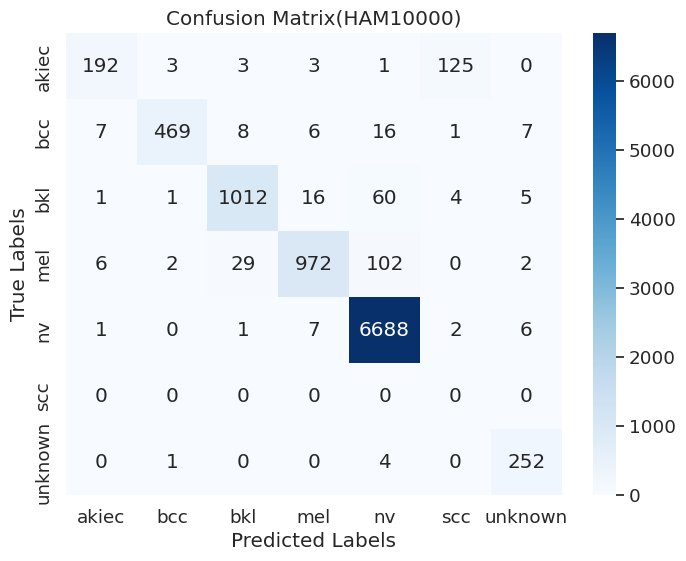


Multiclass Accuracy(HAM10000): 0.9570644033949076
HAM10000 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.927536  0.587156  0.719101    327.000000
bcc            0.985294  0.912451  0.947475    514.000000
bkl            0.961064  0.920837  0.940520   1099.000000
mel            0.968127  0.873315  0.918281   1113.000000
nv             0.973366  0.997465  0.985268   6705.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.926471  0.980545  0.952741    257.000000
accuracy       0.957064  0.957064  0.957064      0.957064
macro avg      0.820265  0.753110  0.780484  10015.000000
weighted avg   0.969346  0.957064  0.961448  10015.000000

Multiclass ROC AUC Score(HAM10000): 0.9336628571554444


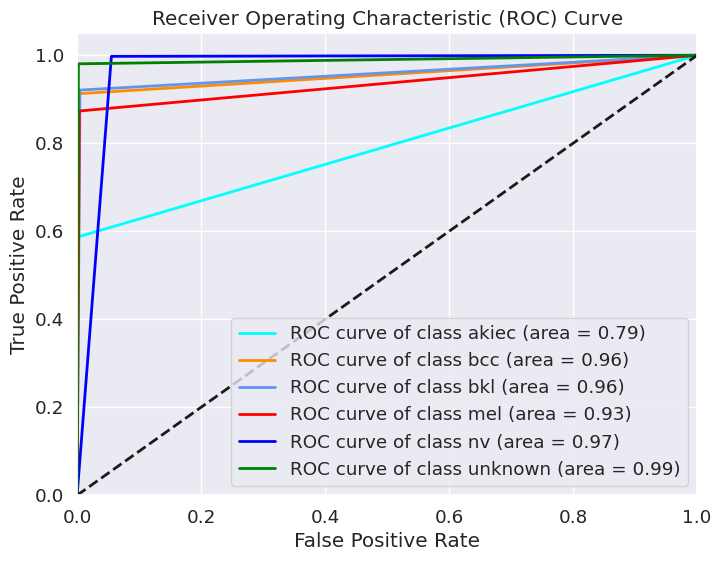

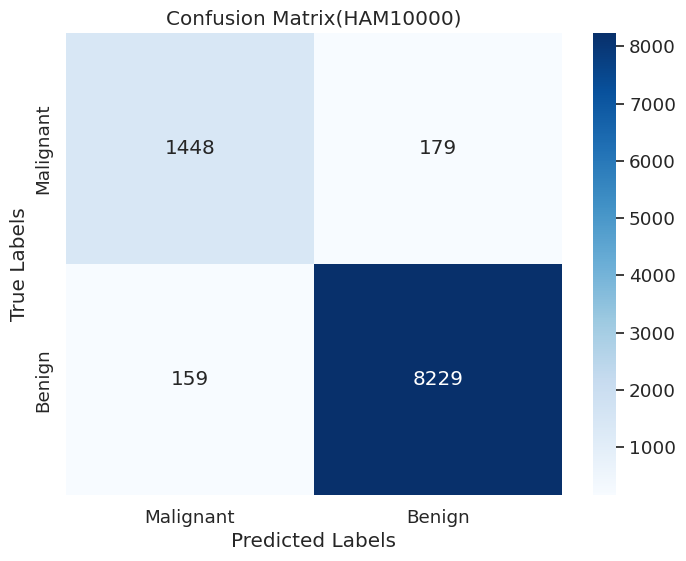


Binary Class Accuracy(HAM10000): 0.9662506240639042
HAM10000 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.901058  0.889982  0.895485   1627.000000
Benign         0.978711  0.981044  0.979876   8388.000000
accuracy       0.966251  0.966251  0.966251      0.966251
macro avg      0.939884  0.935513  0.937681  10015.000000
weighted avg   0.966096  0.966251  0.966166  10015.000000

Binary Class ROC AUC Score(HAM10000): 0.9355129551128005


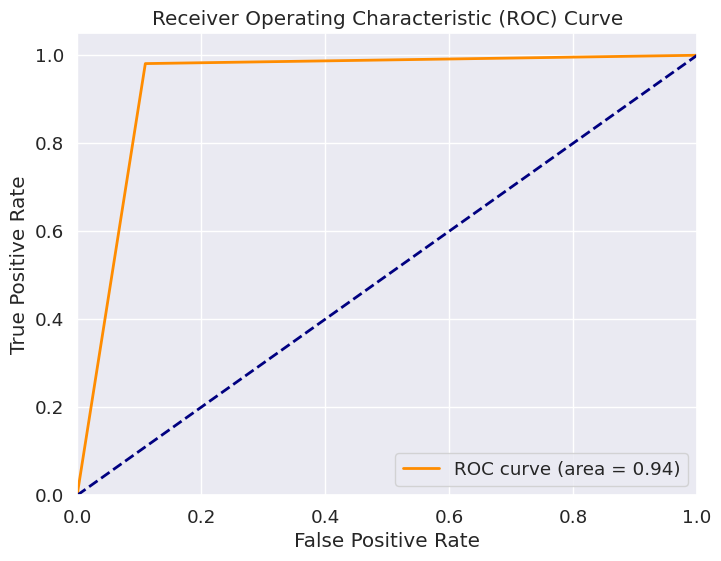

In [3]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/HAM10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    27124
nv          5193
mel          584
bkl          225
Name: count, dtype: int64
label
6    27124
4     5193
3      584
2      225
Name: count, dtype: int64
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step


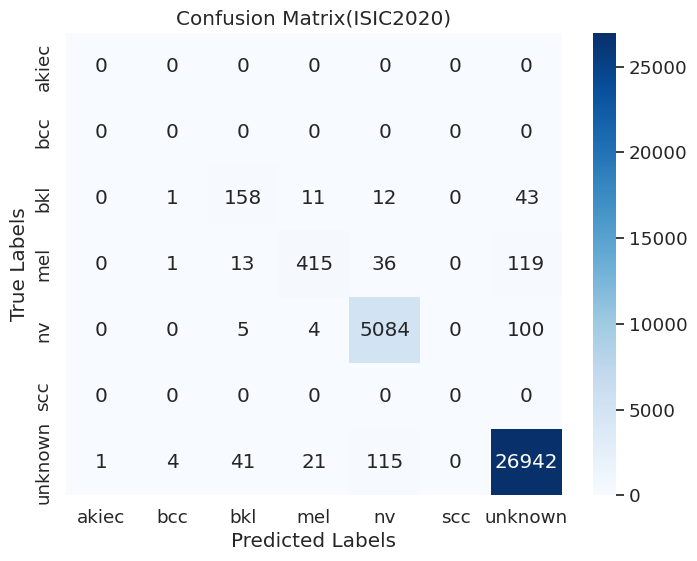


Multiclass Accuracy(ISIC2020): 0.984091046308036
ISIC2020 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.000000  0.000000  0.000000      0.000000
bcc            0.000000  0.000000  0.000000      0.000000
bkl            0.728111  0.702222  0.714932    225.000000
mel            0.920177  0.710616  0.801932    584.000000
nv             0.968935  0.979010  0.973946   5193.000000
unknown        0.990369  0.993290  0.991827  27124.000000
accuracy       0.984091  0.984091  0.984091      0.984091
macro avg      0.601265  0.564190  0.580440  33126.000000
weighted avg   0.983990  0.984091  0.983796  33126.000000

Multiclass ROC AUC Score(ISIC2020): 0.9165939891004802


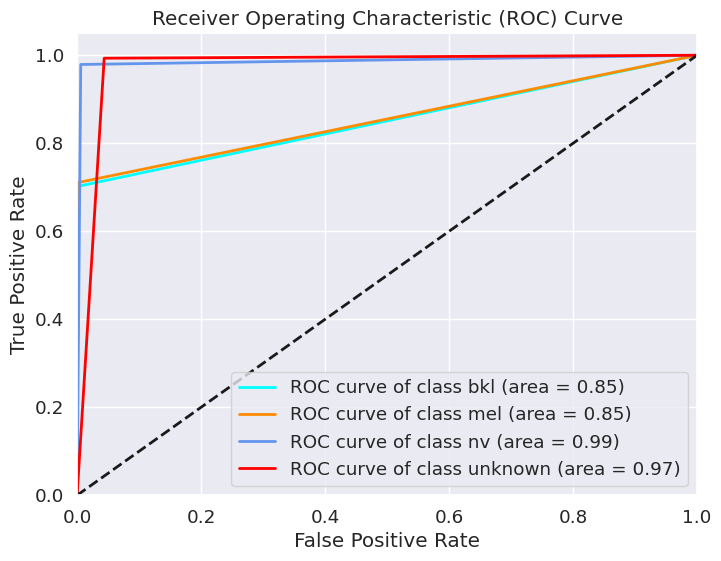

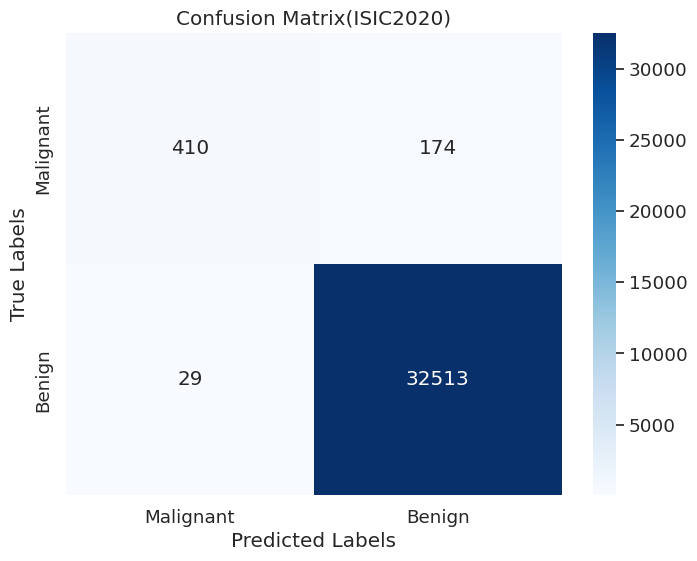


Binary Class Accuracy(ISIC2020): 0.9938718831129626
ISIC2020 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.933941  0.702055  0.801564    584.000000
Benign         0.994677  0.999109  0.996888  32542.000000
accuracy       0.993872  0.993872  0.993872      0.993872
macro avg      0.964309  0.850582  0.899226  33126.000000
weighted avg   0.993606  0.993872  0.993444  33126.000000

Binary Class ROC AUC Score(ISIC2020): 0.8505818192380259


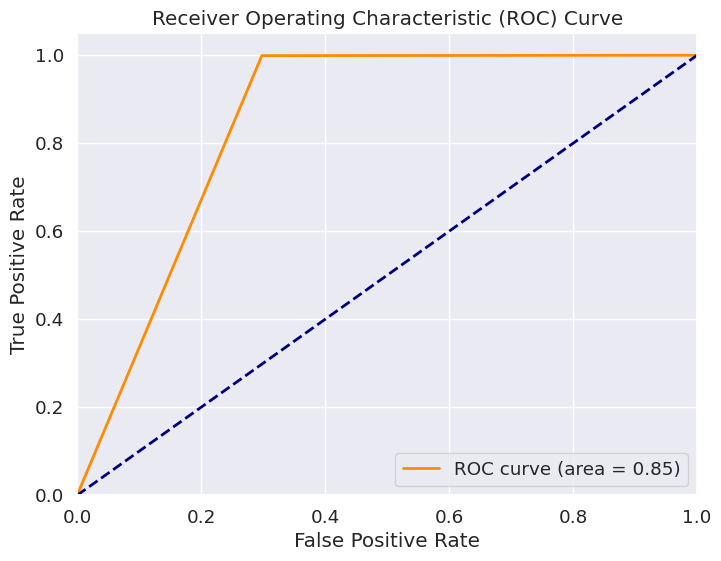

In [5]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         12875
mel         4522
bcc         3323
bkl         2624
akiec        867
scc          628
unknown      492
Name: count, dtype: int64
label
4    12875
3     4522
1     3323
2     2624
0      867
5      628
6      492
Name: count, dtype: int64
792/792 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step
792/792 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step
792/792 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step


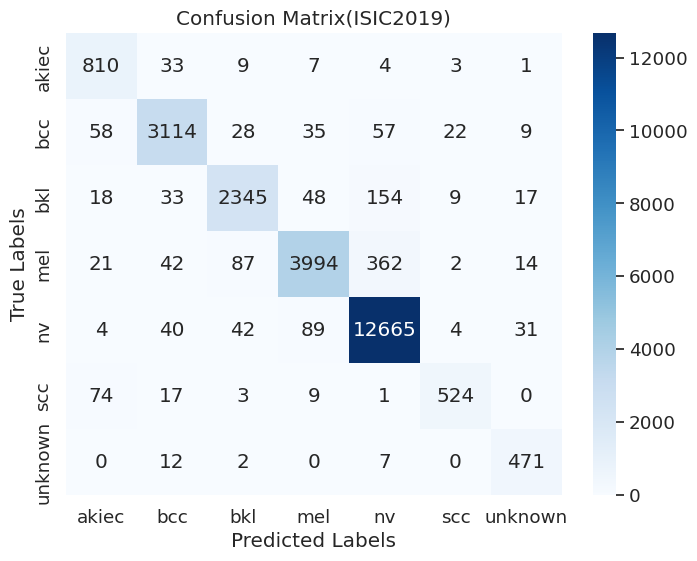


Multiclass Accuracy(ISIC2019): 0.9444159330464648
ISIC2019 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.822335  0.934256  0.874730    867.000000
bcc            0.946217  0.937105  0.941639   3323.000000
bkl            0.932035  0.893674  0.912451   2624.000000
mel            0.955045  0.883238  0.917739   4522.000000
nv             0.955849  0.983689  0.969569  12875.000000
scc            0.929078  0.834395  0.879195    628.000000
unknown        0.867403  0.957317  0.910145    492.000000
accuracy       0.944416  0.944416  0.944416      0.944416
macro avg      0.915423  0.917668  0.915067  25331.000000
weighted avg   0.945024  0.944416  0.944095  25331.000000

Multiclass ROC AUC Score(ISIC2019): 0.9528878053677656


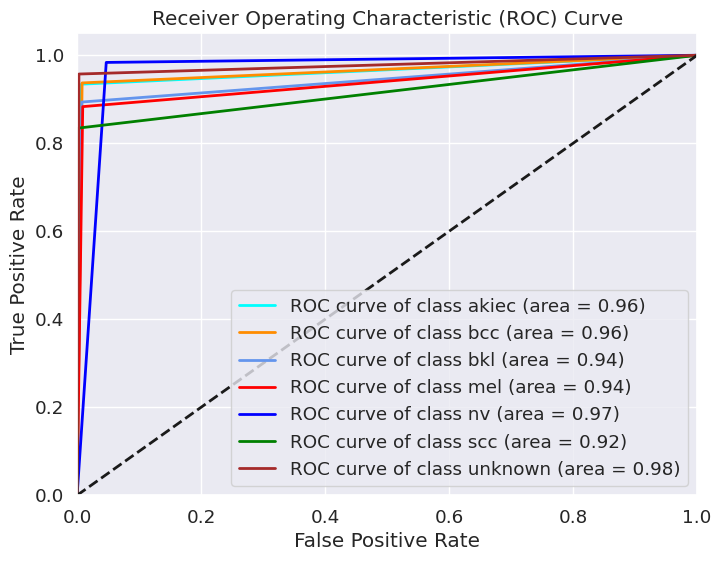

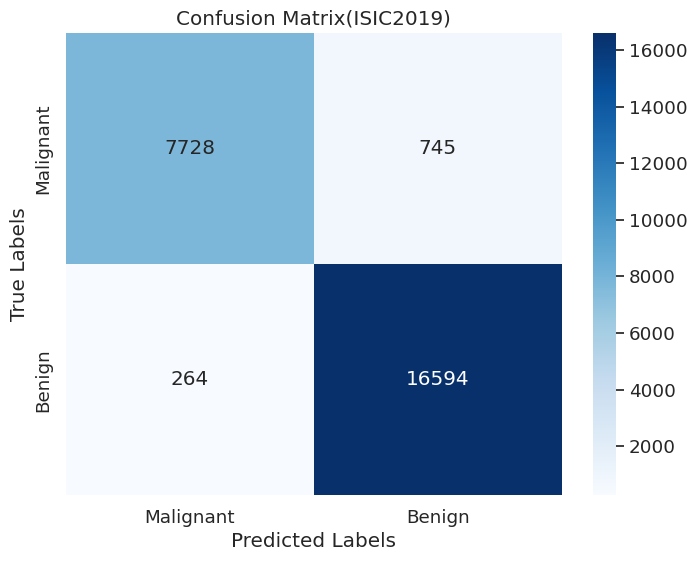


Binary Class Accuracy(ISIC2019): 0.9601673838379851
ISIC2019 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.966967  0.912074  0.938718   8473.000000
Benign         0.957033  0.984340  0.970494  16858.000000
accuracy       0.960167  0.960167  0.960167      0.960167
macro avg      0.962000  0.948207  0.954606  25331.000000
weighted avg   0.960356  0.960167  0.959866  25331.000000

Binary Class ROC AUC Score(ISIC2019): 0.948206712515677


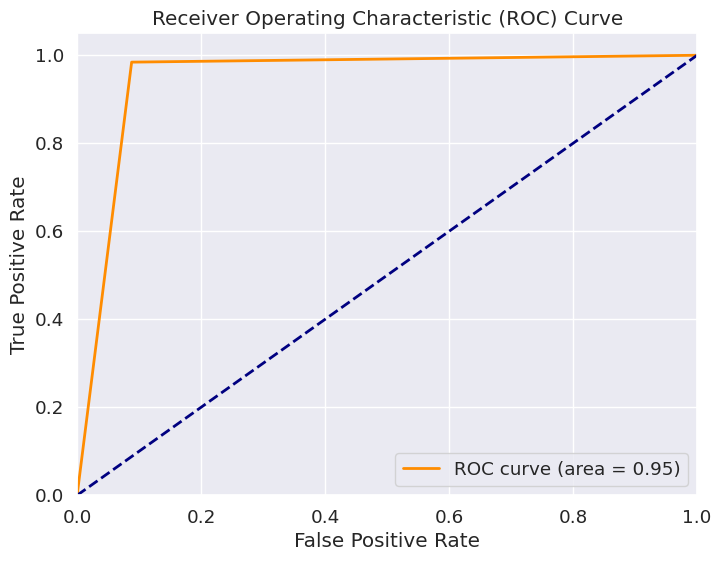

In [6]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step


W0000 00:00:1714664910.773407     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.773770     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.774174     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.774523     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.774868     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.775181     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.775493     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714664910.775820     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 63s 29ms/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step


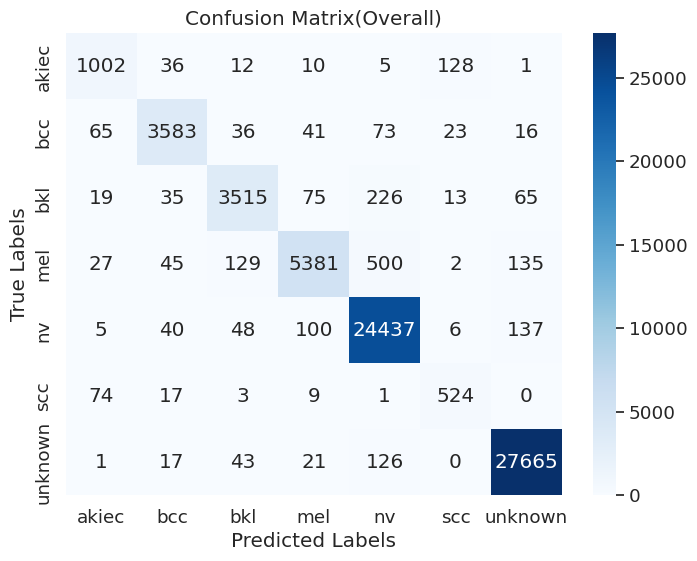


Multiclass Accuracy(Overall): 0.9654603341511859
Overall Multiclass Classification Report():
              precision    recall  f1-score      support
akiec          0.839899  0.839196  0.839548   1194.00000
bcc            0.949642  0.933802  0.941656   3837.00000
bkl            0.928420  0.890324  0.908973   3948.00000
mel            0.954586  0.865252  0.907726   6219.00000
nv             0.963300  0.986437  0.974731  24773.00000
scc            0.752874  0.834395  0.791541    628.00000
unknown        0.987366  0.992538  0.989945  27873.00000
accuracy       0.965460  0.965460  0.965460      0.96546
macro avg      0.910870  0.905992  0.907731  68472.00000
weighted avg   0.965447  0.965460  0.965156  68472.00000

Multiclass ROC AUC Score(Overall): 0.9496638103834785


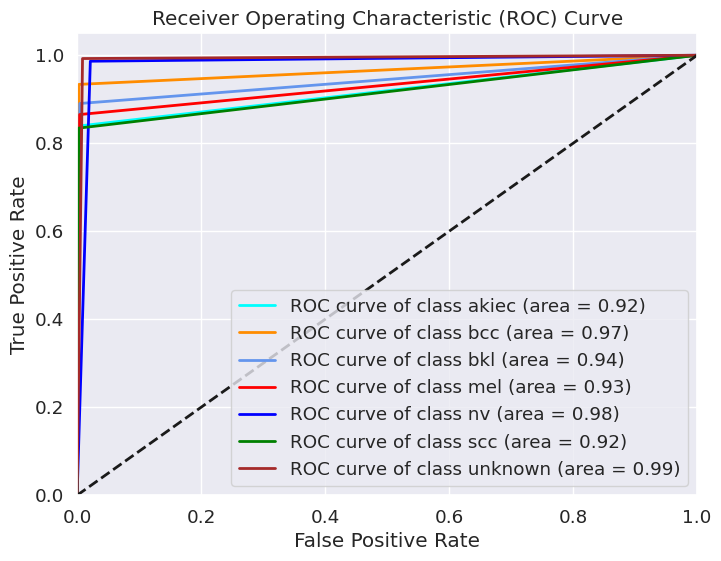

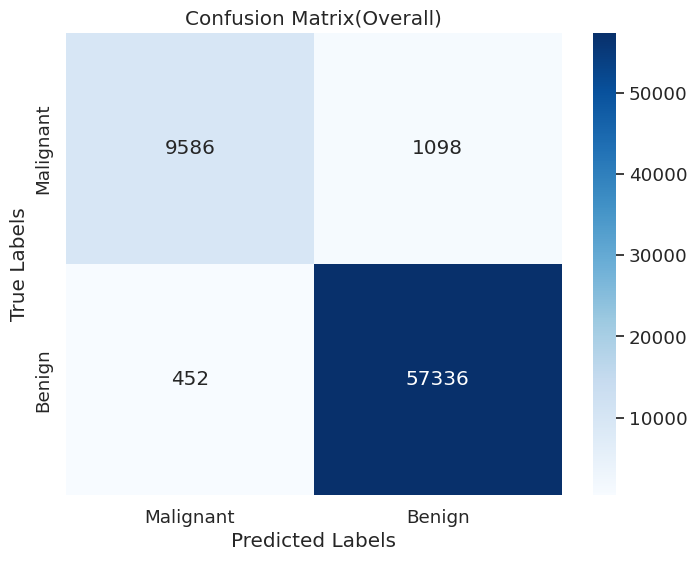


Binary Class Accuracy(Overall): 0.9773630096973945
Overall Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.954971  0.897230  0.925200  10684.000000
Benign         0.981210  0.992178  0.986663  57788.000000
accuracy       0.977363  0.977363  0.977363      0.977363
macro avg      0.968090  0.944704  0.955932  68472.000000
weighted avg   0.977115  0.977363  0.977073  68472.000000

Binary Class ROC AUC Score(Overall): 0.9447039044870421


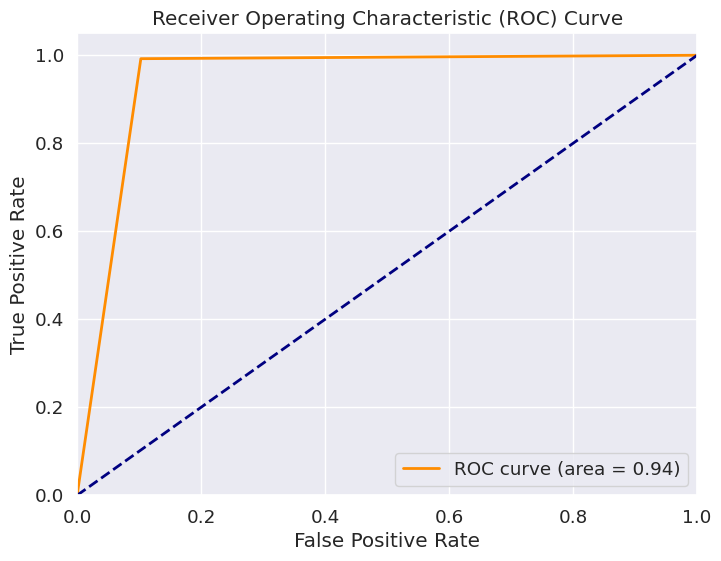

In [7]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


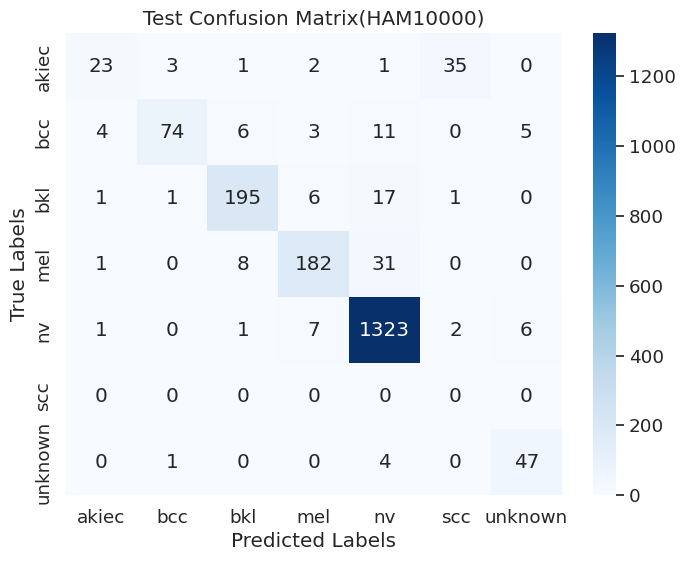


Multiclass Testing Accuracy(HAM10000): 0.9206190713929107
HAM10000 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.766667  0.353846  0.484211    65.000000
bcc            0.936709  0.718447  0.813187   103.000000
bkl            0.924171  0.882353  0.902778   221.000000
mel            0.910000  0.819820  0.862559   222.000000
nv             0.953857  0.987313  0.970297  1340.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.810345  0.903846  0.854545    52.000000
accuracy       0.920619  0.920619  0.920619     0.920619
macro avg      0.757393  0.666518  0.698225  2003.000000
weighted avg   0.935039  0.920619  0.924048  2003.000000

Multiclass Testing ROC AUC Score(HAM10000): 0.878177261814938


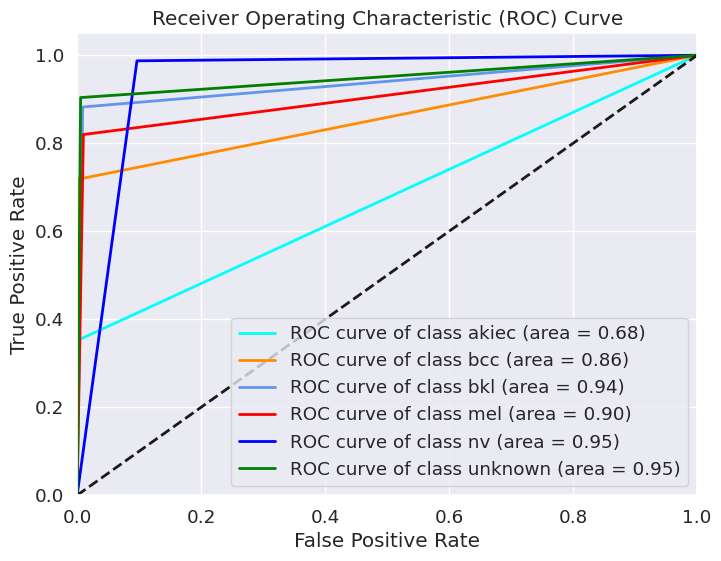

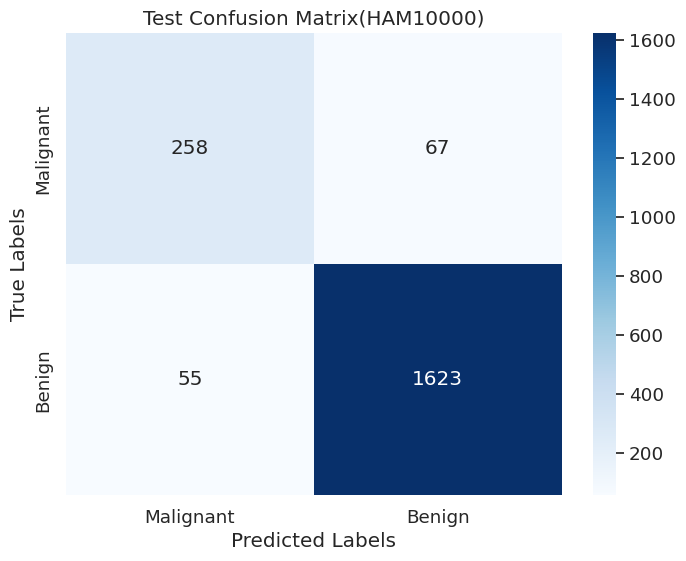


Binary Class Testing Accuracy(HAM10000): 0.9390913629555666
HAM10000 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.824281  0.793846  0.808777   325.000000
Benign         0.960355  0.967223  0.963777  1678.000000
accuracy       0.939091  0.939091  0.939091     0.939091
macro avg      0.892318  0.880535  0.886277  2003.000000
weighted avg   0.938276  0.939091  0.938627  2003.000000

Binary Class ROC AUC Score(HAM10000): 0.880534519116164


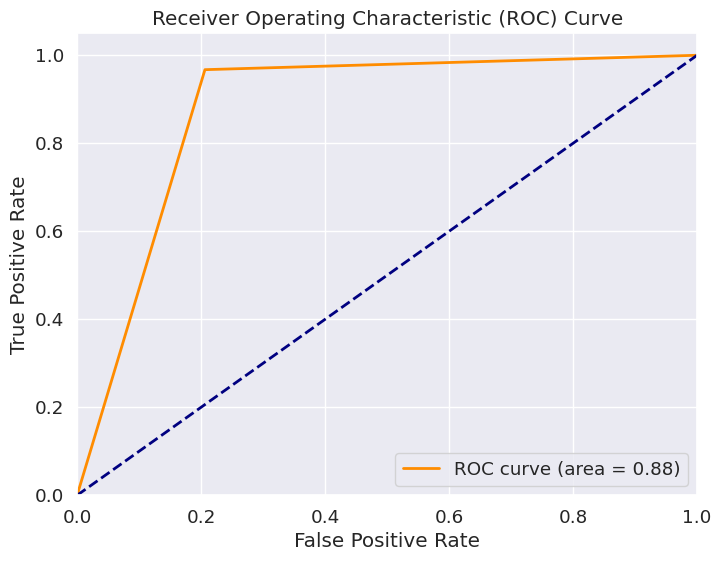

In [8]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


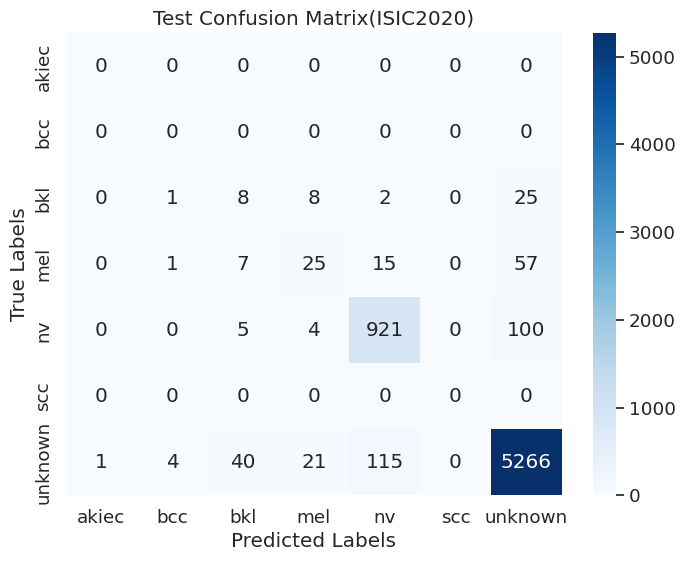


Multiclass Testing Accuracy(ISIC2020): 0.9387262300030184
ISIC2020 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.000000  0.000000  0.000000     0.000000
bcc            0.000000  0.000000  0.000000     0.000000
bkl            0.133333  0.181818  0.153846    44.000000
mel            0.431034  0.238095  0.306748   105.000000
nv             0.874644  0.894175  0.884301  1030.000000
unknown        0.966593  0.966771  0.966682  5447.000000
accuracy       0.938726  0.938726  0.938726     0.938726
macro avg      0.400934  0.380143  0.385263  6626.000000
weighted avg   0.938280  0.938726  0.938021  6626.000000

Multiclass Testing ROC AUC Score(ISIC2020): 0.7612426978723067


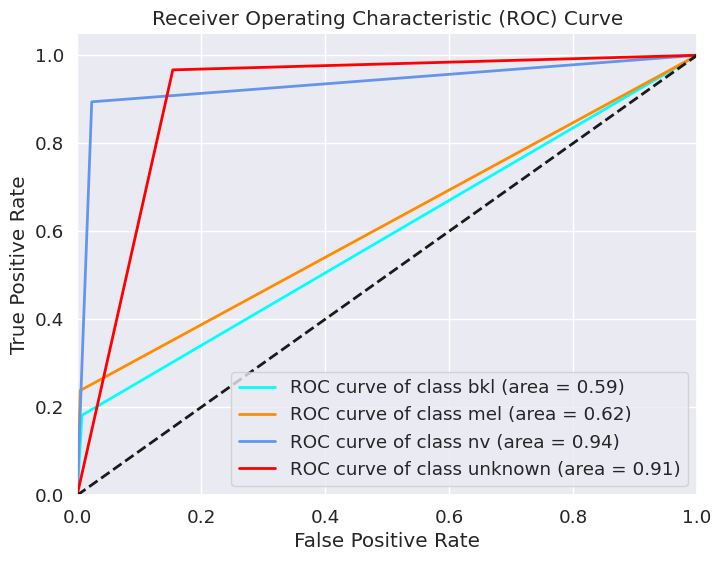

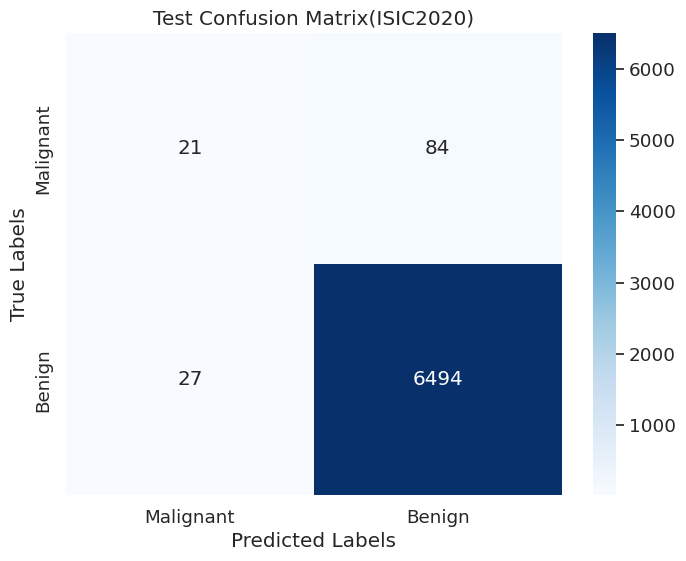


Binary Class Testing Accuracy(ISIC2020): 0.9832478116510716
ISIC2020 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.437500  0.200000  0.274510   105.000000
Benign         0.987230  0.995860  0.991526  6521.000000
accuracy       0.983248  0.983248  0.983248     0.983248
macro avg      0.712365  0.597930  0.633018  6626.000000
weighted avg   0.978519  0.983248  0.980164  6626.000000

Binary Class ROC AUC Score(ISIC2020): 0.597929765373409


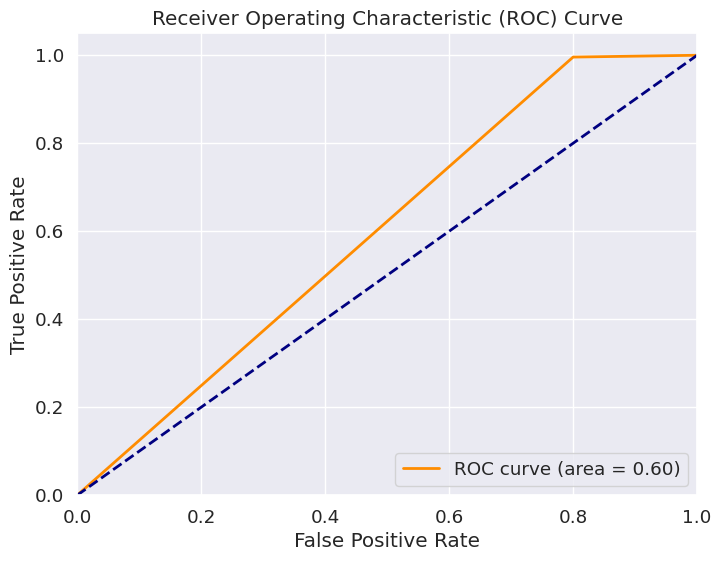

In [12]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)


# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


W0000 00:00:1714665212.566605     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714665212.567082     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714665212.567571     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step


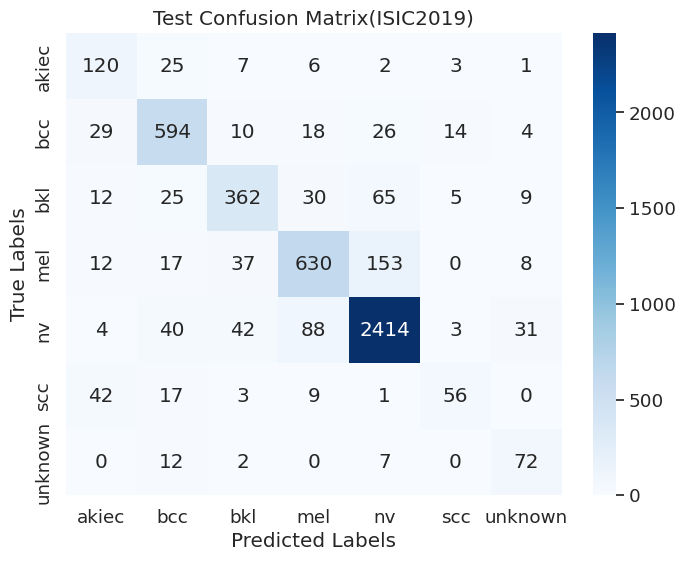


Multiclass Testing Accuracy(ISIC2019): 0.8383658969804618
ISIC2019 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.547945  0.731707  0.626632   164.000000
bcc            0.813699  0.854676  0.833684   695.000000
bkl            0.781857  0.712598  0.745623   508.000000
mel            0.806658  0.735123  0.769231   857.000000
nv             0.904798  0.920671  0.912665  2622.000000
scc            0.691358  0.437500  0.535885   128.000000
unknown        0.576000  0.774194  0.660550    93.000000
accuracy       0.838366  0.838366  0.838366     0.838366
macro avg      0.731759  0.738067  0.726324  5067.000000
weighted avg   0.840401  0.838366  0.837422  5067.000000

Multiclass Testing ROC AUC Score(ISIC2019): 0.852681924472437


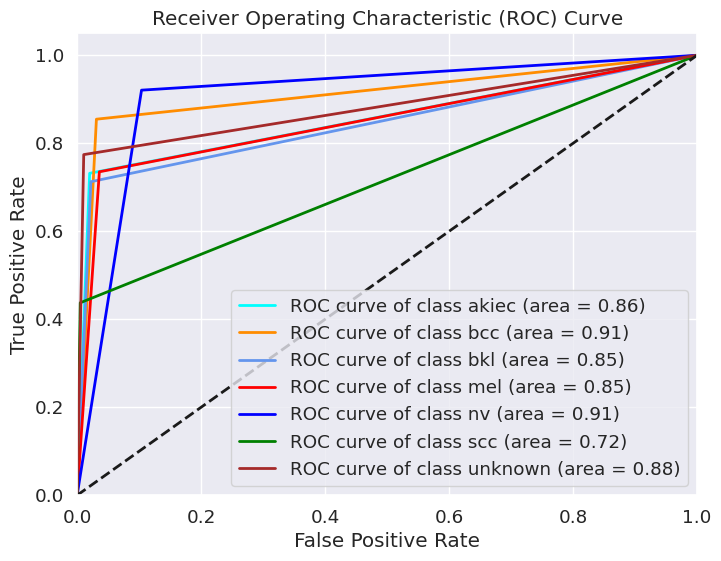

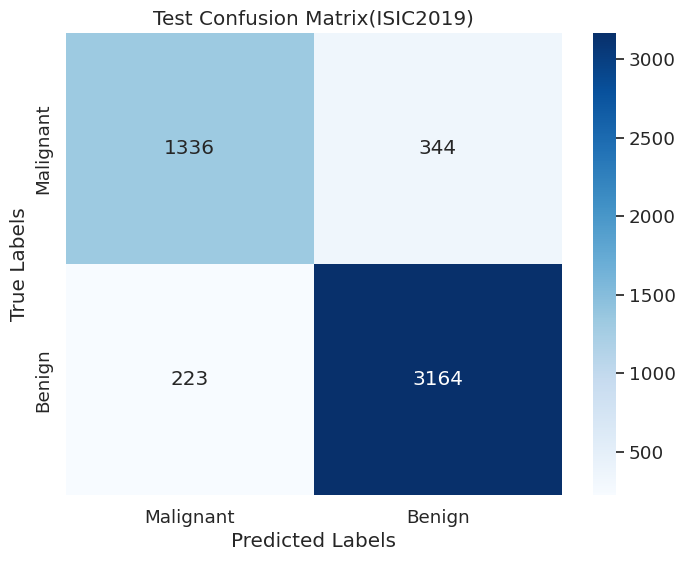


Binary Class Testing Accuracy(ISIC2019): 0.8880994671403197
ISIC2019 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.856960  0.795238  0.824946  1680.000000
Benign         0.901938  0.934160  0.917766  3387.000000
accuracy       0.888099  0.888099  0.888099     0.888099
macro avg      0.879449  0.864699  0.871356  5067.000000
weighted avg   0.887025  0.888099  0.886991  5067.000000

Binary Class ROC AUC Score(ISIC2019): 0.8646990594289089


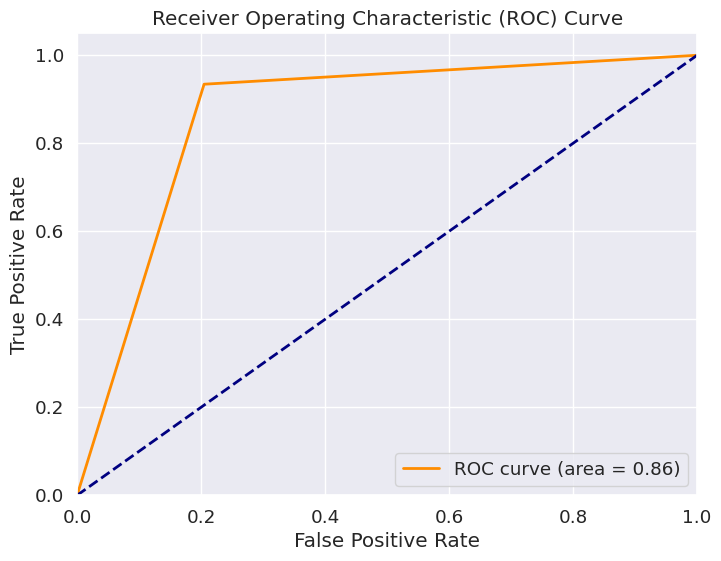

In [10]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

428/428 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step


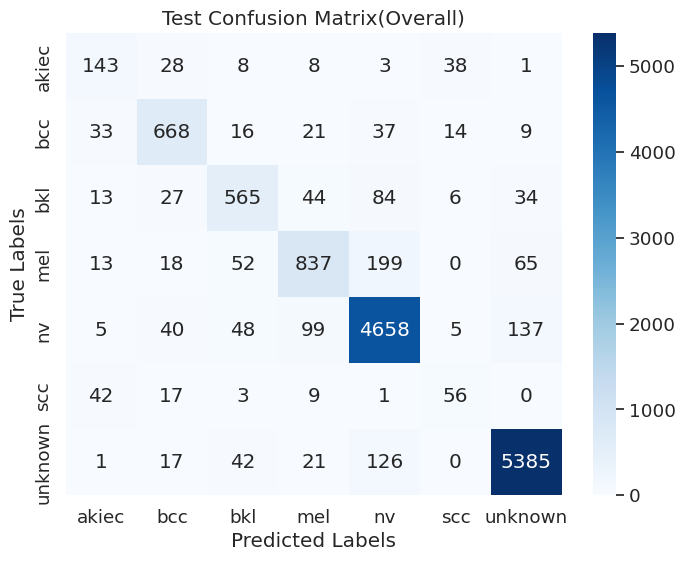


Multiclass Testing Accuracy(Overall): 0.8989485981308412
Overall Multiclass Test Classification Report():
              precision    recall  f1-score       support
akiec          0.572000  0.624454  0.597077    229.000000
bcc            0.819632  0.837093  0.828270    798.000000
bkl            0.769755  0.730918  0.749834    773.000000
mel            0.805582  0.706926  0.753036   1184.000000
nv             0.911903  0.933093  0.922376   4992.000000
scc            0.470588  0.437500  0.453441    128.000000
unknown        0.956313  0.962983  0.959636   5592.000000
accuracy       0.898949  0.898949  0.898949      0.898949
macro avg      0.757968  0.747567  0.751953  13696.000000
weighted avg   0.897637  0.898949  0.897907  13696.000000

Multiclass Testing ROC AUC Score(Overall): 0.8641216704903802


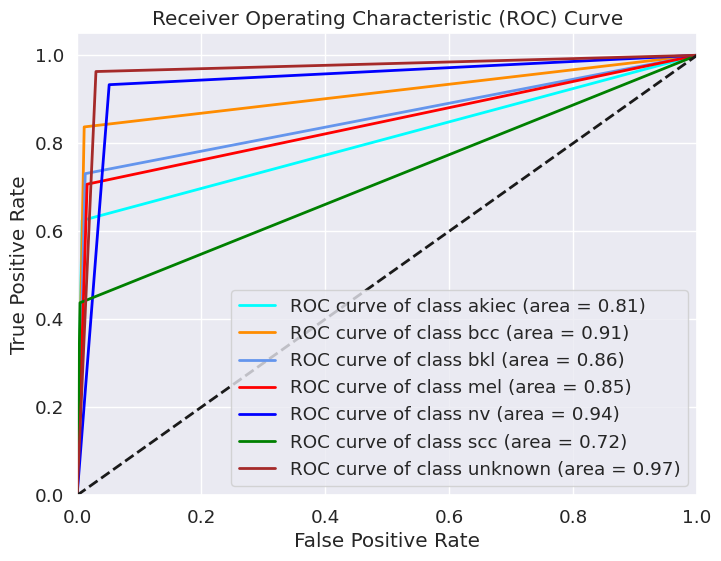

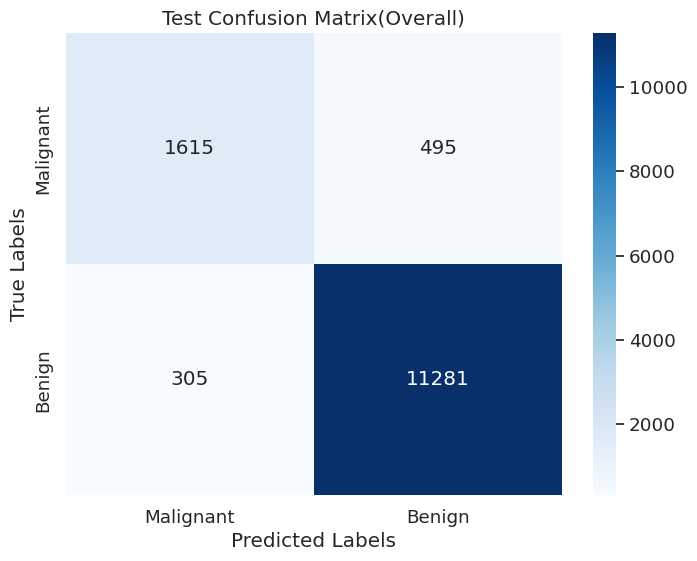


Binary Class Testing Accuracy(Overall): 0.9415887850467289
Overall Binary class Testing Classification Report:
              precision    recall  f1-score       support
Malignant      0.841146  0.765403  0.801489   2110.000000
Benign         0.957965  0.973675  0.965756  11586.000000
accuracy       0.941589  0.941589  0.941589      0.941589
macro avg      0.899556  0.869539  0.883623  13696.000000
weighted avg   0.939968  0.941589  0.940449  13696.000000

Binary Class ROC AUC Score(Overall): 0.86953898437647


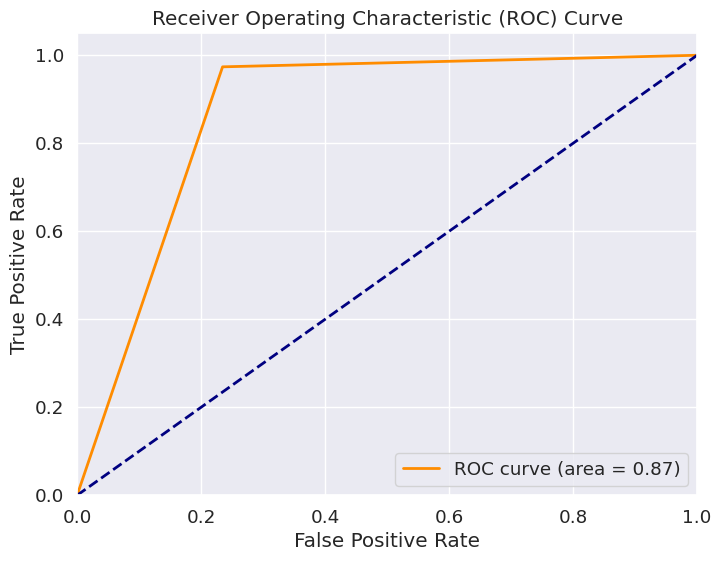

In [11]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
y_pred_convnext = convnext.predict(x_test)
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred_densenet = densenet.predict(x_test)
y_pred_efficientnet = efficientnet.predict(x_test)

# Average the predictions
y_pred_ensemble = (y_pred_densenet + y_pred_efficientnet + y_pred_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new_densenet = np.zeros((y_pred_densenet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_densenet[:, 0] = y_pred_densenet[:, 1] + y_pred_densenet[:, 3] + y_pred_densenet[:, 5]
y_new_densenet[:, 1] = y_pred_densenet[:, 0] + y_pred_densenet[:, 2] + y_pred_densenet[:, 4] + y_pred_densenet[:, 6]

# Convert y_pred to the new binary format
y_new_efficientnet = np.zeros((y_pred_efficientnet.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_efficientnet[:, 0] = y_pred_efficientnet[:, 1] + y_pred_efficientnet[:, 3] + y_pred_efficientnet[:, 5]
y_new_efficientnet[:, 1] = y_pred_efficientnet[:, 0] + y_pred_efficientnet[:, 2] + y_pred_efficientnet[:, 4] + y_pred_efficientnet[:, 6]


# Convert y_pred to the new binary format
y_new_convnext = np.zeros((y_pred_convnext.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new_convnext[:, 0] = y_pred_convnext[:, 1] + y_pred_convnext[:, 3] + y_pred_convnext[:, 5]
y_new_convnext[:, 1] = y_pred_convnext[:, 0] + y_pred_convnext[:, 2] + y_pred_convnext[:, 4] + y_pred_convnext[:, 6]

# Average the predictions
y_pred_ensemble = (y_new_densenet + y_new_efficientnet + y_new_convnext) / 3

# If your predictions are class probabilities and you want to convert them to class labels
y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()